# GAN 

This notebook trains a [DCGAN](https://arxiv.org/pdf/1511.06434.pdf) on the lsun dataset.

The code is adapted from [pytorch's DCGAN tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) by Nathan Inkawhich.

In [119]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 2024
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  2024


In [104]:
%matplotlib inline

In [120]:
# Root directory for dataset
dataroot = "../input/lsun_bedroom/data0/lsun/bedroom"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

cuda:0


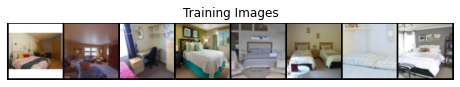

In [121]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:8], padding=2, normalize=True).cpu(),(1,2,0)))

In [122]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [123]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ELU(inplace=True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ELU(inplace=True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ELU(inplace=True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ELU(inplace=True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [124]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0, inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ELU(alpha=1.0, inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ELU(alpha=1.0, inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1,

In [125]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.ELU(inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.ELU(inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.ELU(inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.ELU(inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [126]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ELU(alpha=1.0, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ELU(alpha=1.0, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [127]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(4, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Starting Training Loop...
[0/5][0/2369]	Loss_D: 1.5948	Loss_G: 3.3129	D(x): 0.5089	D(G(z)): 0.4391 / 0.0605


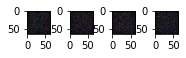

[0/5][50/2369]	Loss_D: 0.6688	Loss_G: 8.5573	D(x): 0.8385	D(G(z)): 0.2781 / 0.0010
[0/5][100/2369]	Loss_D: 0.8408	Loss_G: 2.7520	D(x): 0.5932	D(G(z)): 0.0796 / 0.1016
[0/5][150/2369]	Loss_D: 1.3397	Loss_G: 1.4293	D(x): 0.4158	D(G(z)): 0.0935 / 0.3600
[0/5][200/2369]	Loss_D: 1.0335	Loss_G: 4.7608	D(x): 0.8250	D(G(z)): 0.4642 / 0.0206
[0/5][250/2369]	Loss_D: 0.5290	Loss_G: 2.3795	D(x): 0.7167	D(G(z)): 0.1215 / 0.1209
[0/5][300/2369]	Loss_D: 0.8026	Loss_G: 3.2033	D(x): 0.6958	D(G(z)): 0.2967 / 0.0617
[0/5][350/2369]	Loss_D: 0.6349	Loss_G: 4.4820	D(x): 0.7175	D(G(z)): 0.2081 / 0.0215
[0/5][400/2369]	Loss_D: 0.7586	Loss_G: 3.4943	D(x): 0.6986	D(G(z)): 0.2572 / 0.0415
[0/5][450/2369]	Loss_D: 0.6122	Loss_G: 3.0623	D(x): 0.7577	D(G(z)): 0.2364 / 0.0677
[0/5][500/2369]	Loss_D: 0.9781	Loss_G: 4.3028	D(x): 0.7525	D(G(z)): 0.4114 / 0.0299


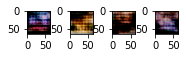

[0/5][550/2369]	Loss_D: 1.3718	Loss_G: 5.3287	D(x): 0.3670	D(G(z)): 0.0069 / 0.0166
[0/5][600/2369]	Loss_D: 0.3010	Loss_G: 4.5553	D(x): 0.8706	D(G(z)): 0.1161 / 0.0158
[0/5][650/2369]	Loss_D: 0.8050	Loss_G: 3.7173	D(x): 0.6327	D(G(z)): 0.1526 / 0.0426
[0/5][700/2369]	Loss_D: 0.7494	Loss_G: 3.8755	D(x): 0.6509	D(G(z)): 0.1747 / 0.0306
[0/5][750/2369]	Loss_D: 0.5995	Loss_G: 4.8618	D(x): 0.6921	D(G(z)): 0.0762 / 0.0270
[0/5][800/2369]	Loss_D: 0.6740	Loss_G: 3.4167	D(x): 0.7288	D(G(z)): 0.2102 / 0.0475
[0/5][850/2369]	Loss_D: 0.3047	Loss_G: 4.8382	D(x): 0.9145	D(G(z)): 0.1679 / 0.0145
[0/5][900/2369]	Loss_D: 0.8445	Loss_G: 6.1300	D(x): 0.7996	D(G(z)): 0.3891 / 0.0045
[0/5][950/2369]	Loss_D: 1.1418	Loss_G: 4.9154	D(x): 0.7454	D(G(z)): 0.4875 / 0.0152
[0/5][1000/2369]	Loss_D: 0.8289	Loss_G: 3.3037	D(x): 0.6761	D(G(z)): 0.2592 / 0.0581


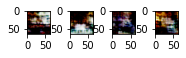

[0/5][1050/2369]	Loss_D: 0.8798	Loss_G: 5.3894	D(x): 0.8192	D(G(z)): 0.4064 / 0.0085
[0/5][1100/2369]	Loss_D: 1.3132	Loss_G: 2.9386	D(x): 0.4143	D(G(z)): 0.0613 / 0.0926
[0/5][1150/2369]	Loss_D: 0.6960	Loss_G: 5.7227	D(x): 0.5952	D(G(z)): 0.0225 / 0.0090
[0/5][1200/2369]	Loss_D: 0.6858	Loss_G: 3.9789	D(x): 0.7600	D(G(z)): 0.2498 / 0.0348
[0/5][1250/2369]	Loss_D: 0.7009	Loss_G: 3.8827	D(x): 0.7602	D(G(z)): 0.2685 / 0.0355
[0/5][1300/2369]	Loss_D: 0.7582	Loss_G: 4.4669	D(x): 0.7716	D(G(z)): 0.3157 / 0.0212
[0/5][1350/2369]	Loss_D: 0.9038	Loss_G: 4.0344	D(x): 0.6186	D(G(z)): 0.2416 / 0.0279
[0/5][1400/2369]	Loss_D: 0.6266	Loss_G: 4.1892	D(x): 0.7752	D(G(z)): 0.2414 / 0.0293
[0/5][1450/2369]	Loss_D: 1.1282	Loss_G: 2.9645	D(x): 0.4662	D(G(z)): 0.0324 / 0.1296
[0/5][1500/2369]	Loss_D: 0.3713	Loss_G: 4.7204	D(x): 0.8900	D(G(z)): 0.1961 / 0.0137


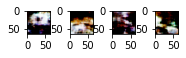

[0/5][1550/2369]	Loss_D: 0.6201	Loss_G: 3.7342	D(x): 0.7499	D(G(z)): 0.2011 / 0.0407
[0/5][1600/2369]	Loss_D: 0.7292	Loss_G: 3.9432	D(x): 0.7433	D(G(z)): 0.2730 / 0.0375
[0/5][1650/2369]	Loss_D: 0.3570	Loss_G: 3.9477	D(x): 0.9166	D(G(z)): 0.2056 / 0.0350
[0/5][1700/2369]	Loss_D: 0.4961	Loss_G: 5.0622	D(x): 0.9147	D(G(z)): 0.2886 / 0.0134
[0/5][1750/2369]	Loss_D: 0.7319	Loss_G: 2.8501	D(x): 0.6720	D(G(z)): 0.1733 / 0.1004
[0/5][1800/2369]	Loss_D: 0.5186	Loss_G: 3.8210	D(x): 0.7032	D(G(z)): 0.0735 / 0.0464
[0/5][1850/2369]	Loss_D: 0.4302	Loss_G: 4.0978	D(x): 0.8616	D(G(z)): 0.1805 / 0.0372
[0/5][1900/2369]	Loss_D: 0.2454	Loss_G: 3.9428	D(x): 0.8987	D(G(z)): 0.1109 / 0.0342
[0/5][1950/2369]	Loss_D: 0.4074	Loss_G: 4.3124	D(x): 0.8941	D(G(z)): 0.2200 / 0.0280
[0/5][2000/2369]	Loss_D: 0.3519	Loss_G: 4.1638	D(x): 0.8758	D(G(z)): 0.1568 / 0.0269


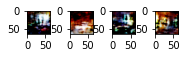

[0/5][2050/2369]	Loss_D: 0.1835	Loss_G: 4.6780	D(x): 0.9361	D(G(z)): 0.0878 / 0.0211
[0/5][2100/2369]	Loss_D: 0.3096	Loss_G: 4.7119	D(x): 0.8235	D(G(z)): 0.0463 / 0.0228
[0/5][2150/2369]	Loss_D: 0.3488	Loss_G: 3.0915	D(x): 0.8825	D(G(z)): 0.1458 / 0.0818
[0/5][2200/2369]	Loss_D: 0.2698	Loss_G: 4.0276	D(x): 0.8779	D(G(z)): 0.0839 / 0.0439
[0/5][2250/2369]	Loss_D: 0.4551	Loss_G: 3.4499	D(x): 0.7994	D(G(z)): 0.1294 / 0.0614
[0/5][2300/2369]	Loss_D: 0.4501	Loss_G: 6.1265	D(x): 0.9271	D(G(z)): 0.2617 / 0.0056
[0/5][2350/2369]	Loss_D: 0.4969	Loss_G: 3.4717	D(x): 0.7303	D(G(z)): 0.0424 / 0.0713
[1/5][0/2369]	Loss_D: 0.3665	Loss_G: 5.5382	D(x): 0.9674	D(G(z)): 0.2427 / 0.0114
[1/5][50/2369]	Loss_D: 0.2494	Loss_G: 5.1560	D(x): 0.8540	D(G(z)): 0.0544 / 0.0209
[1/5][100/2369]	Loss_D: 0.1616	Loss_G: 4.2158	D(x): 0.9530	D(G(z)): 0.0875 / 0.0287


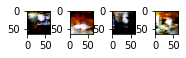

[1/5][150/2369]	Loss_D: 0.2814	Loss_G: 3.5896	D(x): 0.8528	D(G(z)): 0.0682 / 0.0562
[1/5][200/2369]	Loss_D: 0.1680	Loss_G: 5.3130	D(x): 0.8976	D(G(z)): 0.0367 / 0.0156
[1/5][250/2369]	Loss_D: 0.2378	Loss_G: 4.5282	D(x): 0.9391	D(G(z)): 0.1392 / 0.0216
[1/5][300/2369]	Loss_D: 0.3803	Loss_G: 4.3953	D(x): 0.8689	D(G(z)): 0.1620 / 0.0294
[1/5][350/2369]	Loss_D: 0.2458	Loss_G: 5.7323	D(x): 0.9026	D(G(z)): 0.0599 / 0.0281
[1/5][400/2369]	Loss_D: 0.2118	Loss_G: 3.7964	D(x): 0.8807	D(G(z)): 0.0534 / 0.0460
[1/5][450/2369]	Loss_D: 0.2546	Loss_G: 3.8821	D(x): 0.8563	D(G(z)): 0.0525 / 0.0735
[1/5][500/2369]	Loss_D: 0.3983	Loss_G: 5.7220	D(x): 0.9390	D(G(z)): 0.2361 / 0.0092
[1/5][550/2369]	Loss_D: 0.3695	Loss_G: 3.0049	D(x): 0.7865	D(G(z)): 0.0432 / 0.0912
[1/5][600/2369]	Loss_D: 0.1333	Loss_G: 5.6324	D(x): 0.9192	D(G(z)): 0.0339 / 0.0124


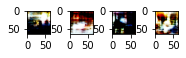

[1/5][650/2369]	Loss_D: 0.2805	Loss_G: 4.9075	D(x): 0.9180	D(G(z)): 0.1261 / 0.0201
[1/5][700/2369]	Loss_D: 0.1624	Loss_G: 5.2028	D(x): 0.9751	D(G(z)): 0.1089 / 0.0156
[1/5][750/2369]	Loss_D: 0.1722	Loss_G: 4.5679	D(x): 0.9480	D(G(z)): 0.0866 / 0.0222
[1/5][800/2369]	Loss_D: 0.2041	Loss_G: 3.4441	D(x): 0.8899	D(G(z)): 0.0560 / 0.0591
[1/5][850/2369]	Loss_D: 0.2309	Loss_G: 3.9484	D(x): 0.8731	D(G(z)): 0.0622 / 0.0475
[1/5][900/2369]	Loss_D: 0.2044	Loss_G: 4.1439	D(x): 0.8922	D(G(z)): 0.0614 / 0.0433
[1/5][950/2369]	Loss_D: 0.1530	Loss_G: 5.0722	D(x): 0.9600	D(G(z)): 0.0836 / 0.0186
[1/5][1000/2369]	Loss_D: 0.2530	Loss_G: 3.2766	D(x): 0.8611	D(G(z)): 0.0537 / 0.0882
[1/5][1050/2369]	Loss_D: 0.2470	Loss_G: 3.9983	D(x): 0.8748	D(G(z)): 0.0771 / 0.0510
[1/5][1100/2369]	Loss_D: 0.1902	Loss_G: 3.0125	D(x): 0.8949	D(G(z)): 0.0372 / 0.1224


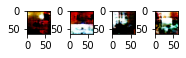

[1/5][1150/2369]	Loss_D: 0.2010	Loss_G: 4.1733	D(x): 0.8897	D(G(z)): 0.0328 / 0.0595
[1/5][1200/2369]	Loss_D: 0.1189	Loss_G: 5.7115	D(x): 0.9508	D(G(z)): 0.0547 / 0.0104
[1/5][1250/2369]	Loss_D: 0.1743	Loss_G: 6.8887	D(x): 0.9873	D(G(z)): 0.1288 / 0.0022
[1/5][1300/2369]	Loss_D: 0.2047	Loss_G: 5.6559	D(x): 0.9599	D(G(z)): 0.1227 / 0.0079
[1/5][1350/2369]	Loss_D: 0.2168	Loss_G: 3.5308	D(x): 0.8877	D(G(z)): 0.0536 / 0.0542
[1/5][1400/2369]	Loss_D: 0.2310	Loss_G: 5.4683	D(x): 0.9514	D(G(z)): 0.1305 / 0.0167
[1/5][1450/2369]	Loss_D: 0.0864	Loss_G: 5.5027	D(x): 0.9662	D(G(z)): 0.0464 / 0.0116
[1/5][1500/2369]	Loss_D: 0.2543	Loss_G: 4.6869	D(x): 0.9080	D(G(z)): 0.1106 / 0.0214
[1/5][1550/2369]	Loss_D: 0.1682	Loss_G: 4.7495	D(x): 0.9386	D(G(z)): 0.0760 / 0.0210
[1/5][1600/2369]	Loss_D: 0.1598	Loss_G: 4.2843	D(x): 0.9277	D(G(z)): 0.0635 / 0.0273


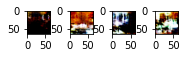

[1/5][1650/2369]	Loss_D: 0.1504	Loss_G: 5.4658	D(x): 0.9635	D(G(z)): 0.0889 / 0.0107
[1/5][1700/2369]	Loss_D: 0.2266	Loss_G: 4.4741	D(x): 0.8864	D(G(z)): 0.0503 / 0.0306
[1/5][1750/2369]	Loss_D: 0.1107	Loss_G: 4.7607	D(x): 0.9411	D(G(z)): 0.0317 / 0.0234
[1/5][1800/2369]	Loss_D: 0.1890	Loss_G: 5.4721	D(x): 0.9586	D(G(z)): 0.1061 / 0.0147
[1/5][1850/2369]	Loss_D: 0.2866	Loss_G: 4.8029	D(x): 0.8850	D(G(z)): 0.0658 / 0.0350
[1/5][1900/2369]	Loss_D: 0.1371	Loss_G: 5.6734	D(x): 0.9202	D(G(z)): 0.0347 / 0.0103
[1/5][1950/2369]	Loss_D: 0.1169	Loss_G: 4.8702	D(x): 0.9372	D(G(z)): 0.0354 / 0.0226
[1/5][2000/2369]	Loss_D: 0.1752	Loss_G: 5.1300	D(x): 0.9500	D(G(z)): 0.0795 / 0.0209
[1/5][2050/2369]	Loss_D: 0.2344	Loss_G: 4.9898	D(x): 0.9548	D(G(z)): 0.1458 / 0.0180
[1/5][2100/2369]	Loss_D: 0.1601	Loss_G: 5.3573	D(x): 0.8995	D(G(z)): 0.0208 / 0.0193


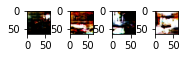

[1/5][2150/2369]	Loss_D: 0.1360	Loss_G: 5.7770	D(x): 0.9806	D(G(z)): 0.1002 / 0.0070
[1/5][2200/2369]	Loss_D: 0.1195	Loss_G: 5.1564	D(x): 0.9563	D(G(z)): 0.0571 / 0.0162
[1/5][2250/2369]	Loss_D: 0.0698	Loss_G: 5.7567	D(x): 0.9720	D(G(z)): 0.0330 / 0.0087
[1/5][2300/2369]	Loss_D: 0.1137	Loss_G: 4.9772	D(x): 0.9516	D(G(z)): 0.0369 / 0.0233
[1/5][2350/2369]	Loss_D: 0.0915	Loss_G: 4.2110	D(x): 0.9715	D(G(z)): 0.0540 / 0.0426
[2/5][0/2369]	Loss_D: 0.0558	Loss_G: 6.7747	D(x): 0.9644	D(G(z)): 0.0142 / 0.0069
[2/5][50/2369]	Loss_D: 0.1678	Loss_G: 5.8530	D(x): 0.9443	D(G(z)): 0.0750 / 0.0079
[2/5][100/2369]	Loss_D: 0.2340	Loss_G: 8.0300	D(x): 0.9856	D(G(z)): 0.1455 / 0.0018
[2/5][150/2369]	Loss_D: 0.0753	Loss_G: 6.1942	D(x): 0.9492	D(G(z)): 0.0162 / 0.0060
[2/5][200/2369]	Loss_D: 0.1082	Loss_G: 5.9148	D(x): 0.9234	D(G(z)): 0.0135 / 0.0094
[2/5][250/2369]	Loss_D: 0.1493	Loss_G: 5.3722	D(x): 0.9327	D(G(z)): 0.0404 / 0.0145


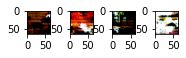

[2/5][300/2369]	Loss_D: 0.1359	Loss_G: 4.9259	D(x): 0.9550	D(G(z)): 0.0687 / 0.0202
[2/5][350/2369]	Loss_D: 0.1429	Loss_G: 6.2774	D(x): 0.9503	D(G(z)): 0.0623 / 0.0052
[2/5][400/2369]	Loss_D: 0.1623	Loss_G: 5.1033	D(x): 0.8850	D(G(z)): 0.0128 / 0.0217
[2/5][450/2369]	Loss_D: 0.1577	Loss_G: 5.7179	D(x): 0.8879	D(G(z)): 0.0078 / 0.0113
[2/5][500/2369]	Loss_D: 0.1400	Loss_G: 7.2519	D(x): 0.9804	D(G(z)): 0.0884 / 0.0023
[2/5][550/2369]	Loss_D: 3.1718	Loss_G: 4.4743	D(x): 0.8220	D(G(z)): 0.4615 / 0.3729
[2/5][600/2369]	Loss_D: 0.6667	Loss_G: 9.8468	D(x): 0.9704	D(G(z)): 0.3516 / 0.0004
[2/5][650/2369]	Loss_D: 0.1851	Loss_G: 4.5827	D(x): 0.9280	D(G(z)): 0.0773 / 0.0288
[2/5][700/2369]	Loss_D: 3.4763	Loss_G: 0.3060	D(x): 0.2097	D(G(z)): 0.0001 / 0.8280
[2/5][750/2369]	Loss_D: 0.1488	Loss_G: 4.3710	D(x): 0.9450	D(G(z)): 0.0724 / 0.0285


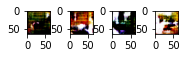

[2/5][800/2369]	Loss_D: 0.1267	Loss_G: 4.4802	D(x): 0.9406	D(G(z)): 0.0479 / 0.0264
[2/5][850/2369]	Loss_D: 0.1066	Loss_G: 5.7924	D(x): 0.9281	D(G(z)): 0.0152 / 0.0139
[2/5][900/2369]	Loss_D: 2.3122	Loss_G: 11.2920	D(x): 0.9816	D(G(z)): 0.6875 / 0.0002
[2/5][950/2369]	Loss_D: 0.1274	Loss_G: 7.2661	D(x): 0.9795	D(G(z)): 0.0856 / 0.0038
[2/5][1000/2369]	Loss_D: 0.1218	Loss_G: 5.0174	D(x): 0.9674	D(G(z)): 0.0723 / 0.0135
[2/5][1050/2369]	Loss_D: 0.0960	Loss_G: 5.1979	D(x): 0.9587	D(G(z)): 0.0431 / 0.0187
[2/5][1100/2369]	Loss_D: 0.1131	Loss_G: 5.9184	D(x): 0.9373	D(G(z)): 0.0285 / 0.0090
[2/5][1150/2369]	Loss_D: 0.0962	Loss_G: 4.4809	D(x): 0.9434	D(G(z)): 0.0307 / 0.0241
[2/5][1200/2369]	Loss_D: 0.1217	Loss_G: 6.2977	D(x): 0.9123	D(G(z)): 0.0072 / 0.0057
[2/5][1250/2369]	Loss_D: 0.1678	Loss_G: 5.5363	D(x): 0.9532	D(G(z)): 0.0892 / 0.0077


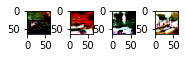

[2/5][1300/2369]	Loss_D: 0.1091	Loss_G: 6.0122	D(x): 0.9831	D(G(z)): 0.0685 / 0.0084
[2/5][1350/2369]	Loss_D: 0.1570	Loss_G: 6.2870	D(x): 0.9550	D(G(z)): 0.0828 / 0.0061
[2/5][1400/2369]	Loss_D: 0.0826	Loss_G: 5.0754	D(x): 0.9709	D(G(z)): 0.0425 / 0.0220
[2/5][1450/2369]	Loss_D: 0.1766	Loss_G: 3.9899	D(x): 0.9041	D(G(z)): 0.0314 / 0.0799
[2/5][1500/2369]	Loss_D: 0.1606	Loss_G: 5.1650	D(x): 0.9414	D(G(z)): 0.0732 / 0.0143
[2/5][1550/2369]	Loss_D: 0.0573	Loss_G: 5.8493	D(x): 0.9550	D(G(z)): 0.0070 / 0.0101
[2/5][1600/2369]	Loss_D: 0.0965	Loss_G: 5.7507	D(x): 0.9654	D(G(z)): 0.0425 / 0.0173
[2/5][1650/2369]	Loss_D: 0.0764	Loss_G: 5.7956	D(x): 0.9523	D(G(z)): 0.0148 / 0.0130
[2/5][1700/2369]	Loss_D: 0.0687	Loss_G: 7.6468	D(x): 0.9513	D(G(z)): 0.0063 / 0.0023
[2/5][1750/2369]	Loss_D: 0.3964	Loss_G: 4.0623	D(x): 0.7554	D(G(z)): 0.0028 / 0.0595


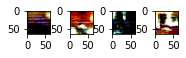

[2/5][1800/2369]	Loss_D: 0.4999	Loss_G: 2.1200	D(x): 0.7281	D(G(z)): 0.0279 / 0.2510
[2/5][1850/2369]	Loss_D: 0.1075	Loss_G: 5.8889	D(x): 0.9719	D(G(z)): 0.0671 / 0.0073
[2/5][1900/2369]	Loss_D: 0.1022	Loss_G: 5.4797	D(x): 0.9442	D(G(z)): 0.0302 / 0.0129
[2/5][1950/2369]	Loss_D: 0.7573	Loss_G: 13.3874	D(x): 0.9897	D(G(z)): 0.3917 / 0.0000
[2/5][2000/2369]	Loss_D: 0.1145	Loss_G: 5.1371	D(x): 0.9527	D(G(z)): 0.0524 / 0.0162
[2/5][2050/2369]	Loss_D: 0.1462	Loss_G: 5.5836	D(x): 0.9337	D(G(z)): 0.0331 / 0.0106
[2/5][2100/2369]	Loss_D: 0.2695	Loss_G: 6.6373	D(x): 0.9410	D(G(z)): 0.1495 / 0.0031
[2/5][2150/2369]	Loss_D: 0.0828	Loss_G: 6.0751	D(x): 0.9561	D(G(z)): 0.0294 / 0.0080
[2/5][2200/2369]	Loss_D: 0.1350	Loss_G: 4.8377	D(x): 0.9230	D(G(z)): 0.0427 / 0.0194
[2/5][2250/2369]	Loss_D: 0.2364	Loss_G: 4.5544	D(x): 0.8901	D(G(z)): 0.0783 / 0.0269


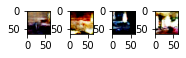

[2/5][2300/2369]	Loss_D: 0.4068	Loss_G: 6.7561	D(x): 0.9045	D(G(z)): 0.1632 / 0.0048
[2/5][2350/2369]	Loss_D: 0.1581	Loss_G: 5.1415	D(x): 0.9243	D(G(z)): 0.0586 / 0.0139
[3/5][0/2369]	Loss_D: 0.1781	Loss_G: 5.1156	D(x): 0.9302	D(G(z)): 0.0717 / 0.0172
[3/5][50/2369]	Loss_D: 0.1000	Loss_G: 5.2938	D(x): 0.9663	D(G(z)): 0.0568 / 0.0141
[3/5][100/2369]	Loss_D: 6.4857	Loss_G: 3.3524	D(x): 0.1254	D(G(z)): 0.0034 / 0.3947
[3/5][150/2369]	Loss_D: 0.3223	Loss_G: 3.4667	D(x): 0.8502	D(G(z)): 0.0799 / 0.0882
[3/5][200/2369]	Loss_D: 0.5791	Loss_G: 2.6027	D(x): 0.6679	D(G(z)): 0.0012 / 0.2528
[3/5][250/2369]	Loss_D: 0.1649	Loss_G: 4.9803	D(x): 0.9251	D(G(z)): 0.0596 / 0.0159
[3/5][300/2369]	Loss_D: 0.2252	Loss_G: 4.0775	D(x): 0.8597	D(G(z)): 0.0415 / 0.0453
[3/5][350/2369]	Loss_D: 0.1625	Loss_G: 4.9438	D(x): 0.9362	D(G(z)): 0.0708 / 0.0221


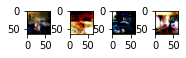

[3/5][400/2369]	Loss_D: 0.2468	Loss_G: 5.4476	D(x): 0.9553	D(G(z)): 0.1446 / 0.0098
[3/5][450/2369]	Loss_D: 0.2783	Loss_G: 6.9740	D(x): 0.9543	D(G(z)): 0.1660 / 0.0021
[3/5][500/2369]	Loss_D: 4.6912	Loss_G: 7.3960	D(x): 0.9949	D(G(z)): 0.7770 / 0.1375
[3/5][550/2369]	Loss_D: 0.2353	Loss_G: 4.4379	D(x): 0.8974	D(G(z)): 0.0643 / 0.0329
[3/5][600/2369]	Loss_D: 0.1452	Loss_G: 4.6505	D(x): 0.9663	D(G(z)): 0.0911 / 0.0214
[3/5][650/2369]	Loss_D: 0.1245	Loss_G: 4.4719	D(x): 0.9623	D(G(z)): 0.0592 / 0.0237
[3/5][700/2369]	Loss_D: 0.1941	Loss_G: 5.0243	D(x): 0.9086	D(G(z)): 0.0687 / 0.0192
[3/5][750/2369]	Loss_D: 0.1337	Loss_G: 6.1076	D(x): 0.8970	D(G(z)): 0.0098 / 0.0077
[3/5][800/2369]	Loss_D: 0.2224	Loss_G: 3.2591	D(x): 0.8525	D(G(z)): 0.0281 / 0.0859
[3/5][850/2369]	Loss_D: 0.3104	Loss_G: 3.9386	D(x): 0.8772	D(G(z)): 0.0828 / 0.0562


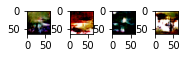

[3/5][900/2369]	Loss_D: 0.1841	Loss_G: 4.3916	D(x): 0.9250	D(G(z)): 0.0772 / 0.0293
[3/5][950/2369]	Loss_D: 0.2959	Loss_G: 3.3019	D(x): 0.8592	D(G(z)): 0.0841 / 0.0780
[3/5][1000/2369]	Loss_D: 1.7716	Loss_G: 2.6646	D(x): 0.3371	D(G(z)): 0.0015 / 0.2225
[3/5][1050/2369]	Loss_D: 0.2204	Loss_G: 3.5870	D(x): 0.8975	D(G(z)): 0.0845 / 0.0493
[3/5][1100/2369]	Loss_D: 0.2428	Loss_G: 3.7703	D(x): 0.8824	D(G(z)): 0.0821 / 0.0485
[3/5][1150/2369]	Loss_D: 0.1379	Loss_G: 4.2915	D(x): 0.9190	D(G(z)): 0.0389 / 0.0280
[3/5][1200/2369]	Loss_D: 0.3928	Loss_G: 3.2048	D(x): 0.7986	D(G(z)): 0.0773 / 0.0994
[3/5][1250/2369]	Loss_D: 0.1856	Loss_G: 4.9869	D(x): 0.8744	D(G(z)): 0.0249 / 0.0156
[3/5][1300/2369]	Loss_D: 0.6590	Loss_G: 7.0077	D(x): 0.9498	D(G(z)): 0.3522 / 0.0019
[3/5][1350/2369]	Loss_D: 0.6589	Loss_G: 3.2894	D(x): 0.6380	D(G(z)): 0.0069 / 0.1030


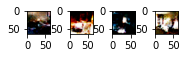

[3/5][1400/2369]	Loss_D: 0.1737	Loss_G: 3.8242	D(x): 0.8996	D(G(z)): 0.0413 / 0.0526
[3/5][1450/2369]	Loss_D: 0.3319	Loss_G: 4.7875	D(x): 0.9166	D(G(z)): 0.1485 / 0.0431
[3/5][1500/2369]	Loss_D: 0.2577	Loss_G: 3.5675	D(x): 0.8897	D(G(z)): 0.1096 / 0.0523
[3/5][1550/2369]	Loss_D: 0.1685	Loss_G: 3.8946	D(x): 0.9015	D(G(z)): 0.0482 / 0.0478
[3/5][1600/2369]	Loss_D: 0.1825	Loss_G: 3.5767	D(x): 0.9011	D(G(z)): 0.0540 / 0.0525
[3/5][1650/2369]	Loss_D: 0.1837	Loss_G: 4.6451	D(x): 0.9614	D(G(z)): 0.1147 / 0.0187
[3/5][1700/2369]	Loss_D: 2.8279	Loss_G: 0.1421	D(x): 0.2654	D(G(z)): 0.0114 / 0.9119
[3/5][1750/2369]	Loss_D: 0.6160	Loss_G: 3.7207	D(x): 0.7655	D(G(z)): 0.1687 / 0.0532
[3/5][1800/2369]	Loss_D: 0.7957	Loss_G: 2.4657	D(x): 0.6201	D(G(z)): 0.0816 / 0.1853
[3/5][1850/2369]	Loss_D: 0.4027	Loss_G: 5.0294	D(x): 0.8862	D(G(z)): 0.2022 / 0.0129


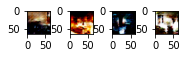

[3/5][1900/2369]	Loss_D: 0.3203	Loss_G: 2.9620	D(x): 0.8002	D(G(z)): 0.0512 / 0.1141
[3/5][1950/2369]	Loss_D: 0.2327	Loss_G: 4.6536	D(x): 0.9587	D(G(z)): 0.1576 / 0.0161
[3/5][2000/2369]	Loss_D: 0.1923	Loss_G: 4.2724	D(x): 0.8818	D(G(z)): 0.0506 / 0.0269
[3/5][2050/2369]	Loss_D: 0.1623	Loss_G: 4.3489	D(x): 0.9482	D(G(z)): 0.0909 / 0.0236
[3/5][2100/2369]	Loss_D: 0.5296	Loss_G: 4.4440	D(x): 0.7586	D(G(z)): 0.1111 / 0.0372
[3/5][2150/2369]	Loss_D: 0.1754	Loss_G: 4.0885	D(x): 0.9375	D(G(z)): 0.0896 / 0.0376
[3/5][2200/2369]	Loss_D: 0.2222	Loss_G: 3.3837	D(x): 0.8908	D(G(z)): 0.0701 / 0.0690
[3/5][2250/2369]	Loss_D: 0.1855	Loss_G: 4.3946	D(x): 0.9220	D(G(z)): 0.0823 / 0.0254
[3/5][2300/2369]	Loss_D: 0.1455	Loss_G: 3.9327	D(x): 0.9408	D(G(z)): 0.0723 / 0.0388
[3/5][2350/2369]	Loss_D: 0.1129	Loss_G: 3.8570	D(x): 0.9414	D(G(z)): 0.0462 / 0.0331
[4/5][0/2369]	Loss_D: 0.1201	Loss_G: 4.2741	D(x): 0.9574	D(G(z)): 0.0665 / 0.0259


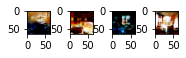

[4/5][50/2369]	Loss_D: 0.3161	Loss_G: 4.2623	D(x): 0.8609	D(G(z)): 0.1060 / 0.0315
[4/5][100/2369]	Loss_D: 0.1742	Loss_G: 4.0485	D(x): 0.8883	D(G(z)): 0.0346 / 0.0313
[4/5][150/2369]	Loss_D: 0.1747	Loss_G: 3.2328	D(x): 0.8883	D(G(z)): 0.0422 / 0.0648
[4/5][200/2369]	Loss_D: 0.1212	Loss_G: 5.1232	D(x): 0.9129	D(G(z)): 0.0173 / 0.0133
[4/5][250/2369]	Loss_D: 0.1998	Loss_G: 3.8601	D(x): 0.8752	D(G(z)): 0.0406 / 0.0415
[4/5][300/2369]	Loss_D: 0.1810	Loss_G: 4.8520	D(x): 0.8824	D(G(z)): 0.0279 / 0.0187
[4/5][350/2369]	Loss_D: 0.4270	Loss_G: 2.4282	D(x): 0.7670	D(G(z)): 0.0829 / 0.1490
[4/5][400/2369]	Loss_D: 0.7938	Loss_G: 9.0534	D(x): 0.9401	D(G(z)): 0.4107 / 0.0005
[4/5][450/2369]	Loss_D: 0.3434	Loss_G: 3.9091	D(x): 0.8217	D(G(z)): 0.0823 / 0.0407
[4/5][500/2369]	Loss_D: 0.1548	Loss_G: 4.3018	D(x): 0.9170	D(G(z)): 0.0533 / 0.0229


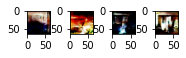

[4/5][550/2369]	Loss_D: 0.1643	Loss_G: 4.3782	D(x): 0.9349	D(G(z)): 0.0811 / 0.0226
[4/5][600/2369]	Loss_D: 0.1459	Loss_G: 4.3100	D(x): 0.9484	D(G(z)): 0.0677 / 0.0285
[4/5][650/2369]	Loss_D: 0.3475	Loss_G: 5.5692	D(x): 0.9200	D(G(z)): 0.1984 / 0.0064
[4/5][700/2369]	Loss_D: 0.2686	Loss_G: 3.7330	D(x): 0.8901	D(G(z)): 0.1150 / 0.0393
[4/5][750/2369]	Loss_D: 0.1203	Loss_G: 3.8511	D(x): 0.9491	D(G(z)): 0.0593 / 0.0436
[4/5][800/2369]	Loss_D: 0.1630	Loss_G: 5.3210	D(x): 0.8909	D(G(z)): 0.0226 / 0.0115
[4/5][850/2369]	Loss_D: 7.3719	Loss_G: 14.5573	D(x): 0.9962	D(G(z)): 0.9232 / 0.0076
[4/5][900/2369]	Loss_D: 1.0382	Loss_G: 4.5492	D(x): 0.7968	D(G(z)): 0.3906 / 0.0414
[4/5][950/2369]	Loss_D: 0.9555	Loss_G: 3.6868	D(x): 0.5454	D(G(z)): 0.0264 / 0.0796
[4/5][1000/2369]	Loss_D: 0.5488	Loss_G: 6.2761	D(x): 0.9588	D(G(z)): 0.3358 / 0.0038


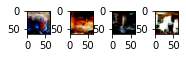

[4/5][1050/2369]	Loss_D: 0.1506	Loss_G: 4.4428	D(x): 0.9355	D(G(z)): 0.0677 / 0.0247
[4/5][1100/2369]	Loss_D: 0.3198	Loss_G: 3.3221	D(x): 0.7795	D(G(z)): 0.0241 / 0.0733
[4/5][1150/2369]	Loss_D: 0.1320	Loss_G: 4.2382	D(x): 0.9417	D(G(z)): 0.0633 / 0.0272
[4/5][1200/2369]	Loss_D: 0.2404	Loss_G: 4.5179	D(x): 0.9456	D(G(z)): 0.1525 / 0.0177
[4/5][1250/2369]	Loss_D: 0.2378	Loss_G: 4.4457	D(x): 0.9659	D(G(z)): 0.1612 / 0.0185
[4/5][1300/2369]	Loss_D: 0.5129	Loss_G: 5.7265	D(x): 0.9620	D(G(z)): 0.2949 / 0.0077
[4/5][1350/2369]	Loss_D: 0.2069	Loss_G: 4.4762	D(x): 0.8835	D(G(z)): 0.0582 / 0.0236
[4/5][1400/2369]	Loss_D: 0.1638	Loss_G: 4.0192	D(x): 0.9417	D(G(z)): 0.0899 / 0.0287
[4/5][1450/2369]	Loss_D: 0.1914	Loss_G: 4.4114	D(x): 0.9290	D(G(z)): 0.0945 / 0.0215
[4/5][1500/2369]	Loss_D: 0.2442	Loss_G: 4.7196	D(x): 0.9356	D(G(z)): 0.1442 / 0.0134


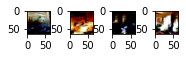

[4/5][1550/2369]	Loss_D: 0.0760	Loss_G: 4.6639	D(x): 0.9755	D(G(z)): 0.0467 / 0.0165
[4/5][1600/2369]	Loss_D: 0.8989	Loss_G: 3.8197	D(x): 0.5869	D(G(z)): 0.0270 / 0.1011
[4/5][1650/2369]	Loss_D: 0.2028	Loss_G: 4.2651	D(x): 0.9161	D(G(z)): 0.0874 / 0.0240
[4/5][1700/2369]	Loss_D: 0.1953	Loss_G: 3.8779	D(x): 0.8748	D(G(z)): 0.0388 / 0.0359
[4/5][1750/2369]	Loss_D: 0.2985	Loss_G: 5.2984	D(x): 0.9576	D(G(z)): 0.1957 / 0.0089
[4/5][1800/2369]	Loss_D: 0.1383	Loss_G: 4.4955	D(x): 0.9654	D(G(z)): 0.0898 / 0.0196
[4/5][1850/2369]	Loss_D: 0.2296	Loss_G: 3.7464	D(x): 0.8962	D(G(z)): 0.0917 / 0.0365
[4/5][1900/2369]	Loss_D: 0.2310	Loss_G: 4.2041	D(x): 0.9425	D(G(z)): 0.1266 / 0.0262
[4/5][1950/2369]	Loss_D: 1.1941	Loss_G: 7.0459	D(x): 0.9607	D(G(z)): 0.5019 / 0.0078
[4/5][2000/2369]	Loss_D: 0.1732	Loss_G: 3.9007	D(x): 0.9066	D(G(z)): 0.0564 / 0.0401


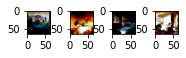

[4/5][2050/2369]	Loss_D: 0.2381	Loss_G: 4.1420	D(x): 0.9445	D(G(z)): 0.1409 / 0.0323
[4/5][2100/2369]	Loss_D: 0.1681	Loss_G: 5.0013	D(x): 0.9459	D(G(z)): 0.0887 / 0.0139
[4/5][2150/2369]	Loss_D: 0.1647	Loss_G: 4.3361	D(x): 0.9439	D(G(z)): 0.0868 / 0.0283
[4/5][2200/2369]	Loss_D: 0.1935	Loss_G: 4.5358	D(x): 0.8633	D(G(z)): 0.0281 / 0.0226
[4/5][2250/2369]	Loss_D: 0.2143	Loss_G: 3.6619	D(x): 0.8811	D(G(z)): 0.0632 / 0.0515
[4/5][2300/2369]	Loss_D: 0.1378	Loss_G: 4.2003	D(x): 0.9410	D(G(z)): 0.0628 / 0.0268
[4/5][2350/2369]	Loss_D: 0.2056	Loss_G: 3.8348	D(x): 0.8851	D(G(z)): 0.0566 / 0.0403


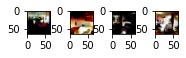

In [128]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            plt.figure()
            i = 0
            for im in fake:
                i += 1
                plt.subplot(8, 8, i)
                plt.imshow(np.transpose(im,(1,2,0)))
            plt.show()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

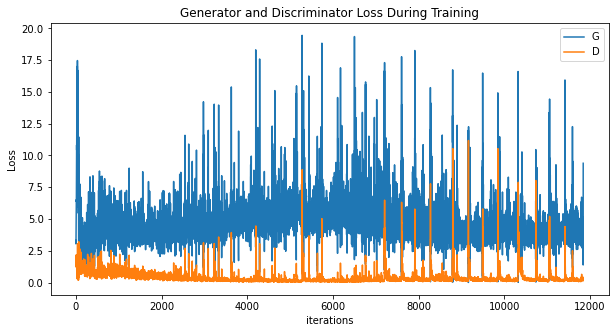

In [129]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

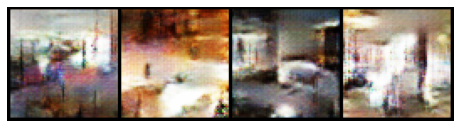

In [130]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

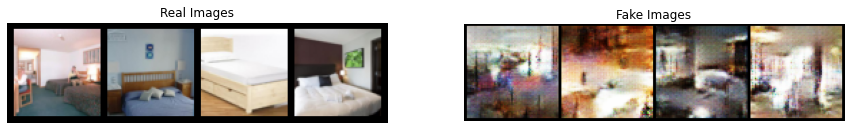

In [131]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:4], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()